In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import cv2
import json

In [12]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    try:
        assert(ds.BodyPartExamined=='CHEST')
        assert(ds.Modality=='DX')
        assert(ds.PatientPosition in ['AP', 'PA'])
    except Exception as e:
        print('File {} contains invalid data'.format(filename))
        print(e)
        return None
    print('File {} loaded successfully!'.format(filename))
    img = ds.pixel_array
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    proc_img = cv2.resize(img, img_size)
    proc_img = cv2.cvtColor(proc_img, cv2.COLOR_GRAY2RGB)
    proc_img = (proc_img - img_mean)/img_std
    return np.expand_dims(proc_img, 0)

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    with open(model_path, 'r') as json_file:
        model_json = json_file.read()
        
        model = keras.models.model_from_json(model_json)
        
        model.load_weights(weight_path)
        
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    prediction = model.predict(img)>thresh    
    
    return prediction 


Load file test1.dcm ...
File test1.dcm loaded successfully!
Pred :False


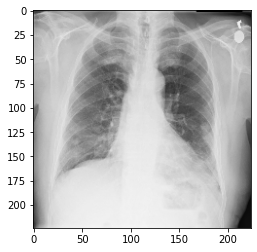

Load file test2.dcm ...
File test2.dcm loaded successfully!
Pred :False


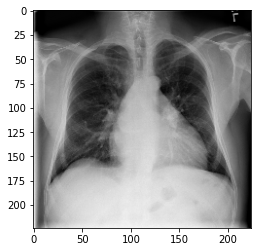

Load file test3.dcm ...
File test3.dcm loaded successfully!
Pred :False


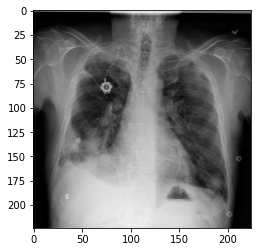

Load file test4.dcm ...
File test4.dcm contains invalid data

Load file test5.dcm ...
File test5.dcm contains invalid data

Load file test6.dcm ...
File test6.dcm contains invalid data



In [13]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "./my_model.json"#path to saved model
weight_path = "./weights/gold.hdf5"#path to saved best weights

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = 0# loads the mean image value they used during training preprocessing
img_std = 255# loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path)
thresh = 0.01 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,0,255,(224,224))
    pred = predict_image(my_model,img_proc,thresh)
    print("Pred :" + str(pred[0,0]))
    plt.imshow(img_proc[0])
    plt.show()